In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

Wczytanie oryginalnego pliku do ramki danych:

In [2]:
glass_org = pd.read_csv('glass.csv')
glass_org

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Oznaczenia klas:<br>
-- 1 building windows float processed<br>
-- 2 building windows non float processed<br> 
-- 3 vehicle windows float processed<br>
-- 4 vehicle windows non float processed (none in this database)<br>
-- 5 containers<br>
-- 6 tableware<br>
-- 7 headlamps

Sprawdzenie czy nie ma braków w danych:

In [3]:
glass_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Obejrzymy teraz wykresy pudełkowe i skrzypcowe oryginalnych danych:

In [4]:
def pokaz_pudelka(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.boxplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.boxplot(x="Type", y=atrybuty[i-2], data=glass)

In [5]:
def pokaz_skrzypce(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.violinplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.violinplot(x="Type", y=atrybuty[i-2], data=glass)

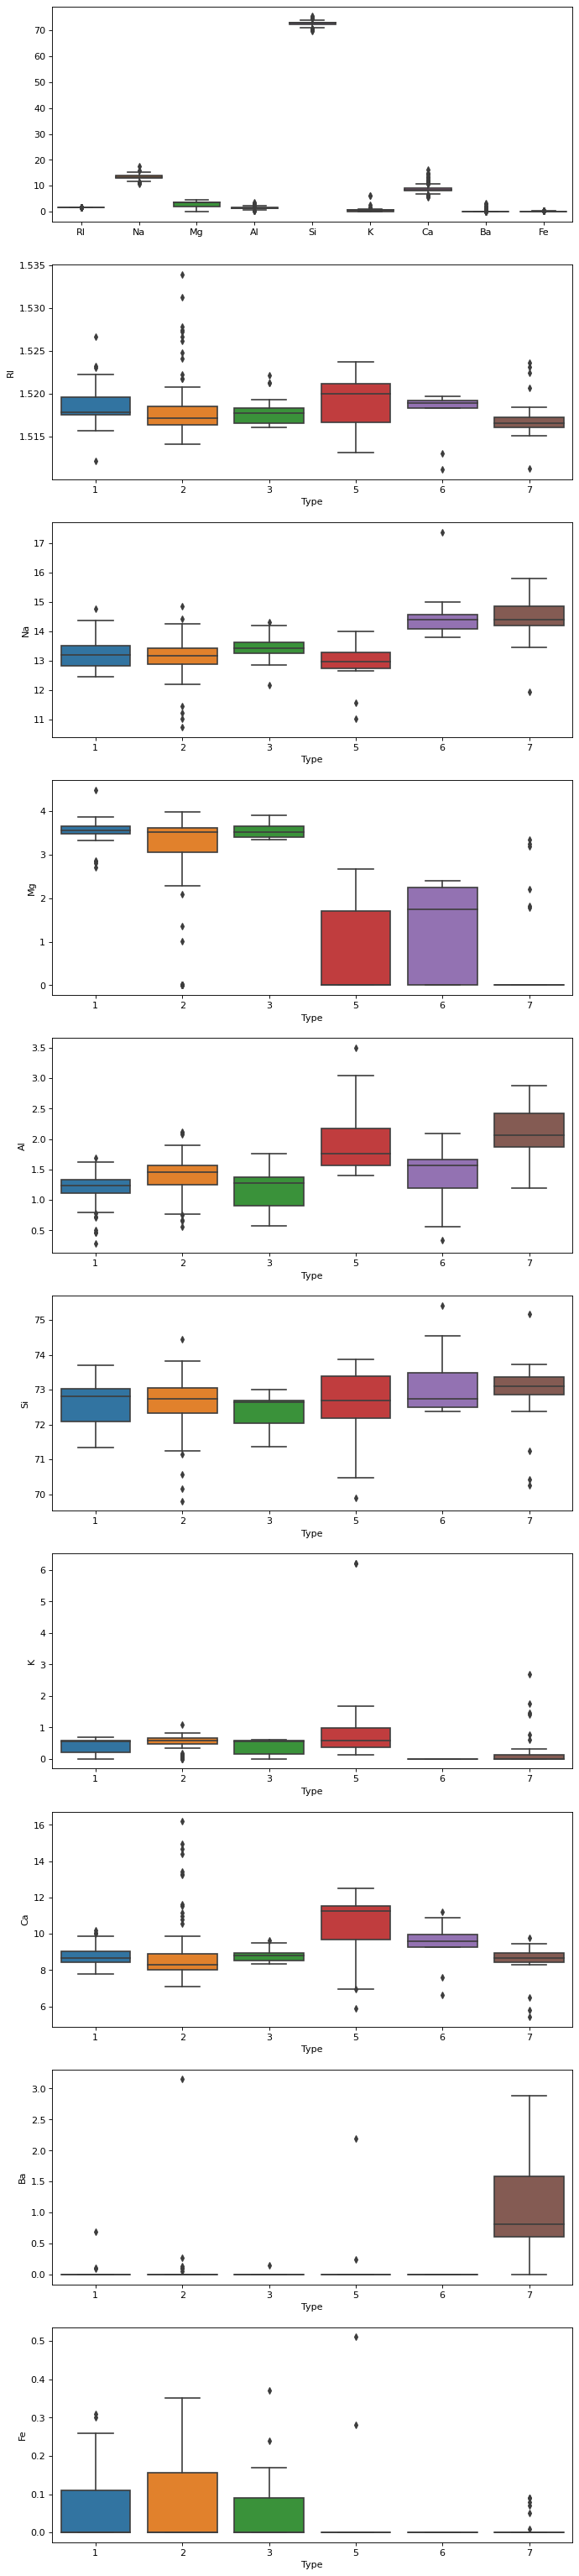

In [6]:
pokaz_pudelka(glass_org)

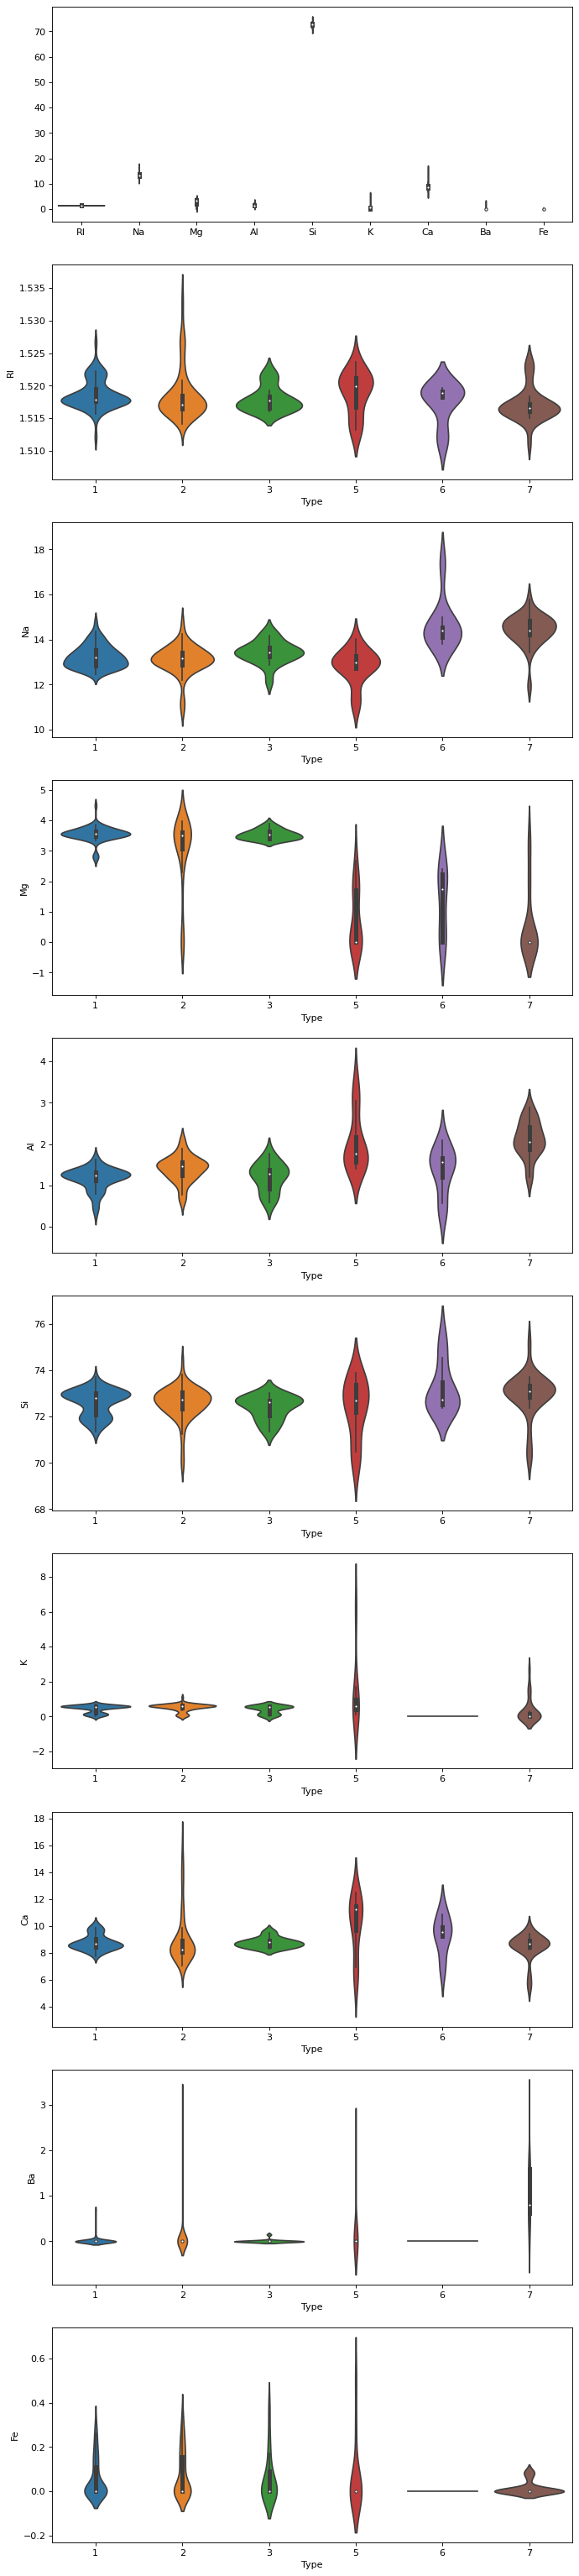

In [7]:
pokaz_skrzypce(glass_org)

Nierówna dystrybucja obiektów klas w zbiorze:

In [8]:
def class_distr(glass):
    ile_ob_klas = []
    for i in range(1,8):
        ile_ob_klas.append(glass[glass.Type == i].shape[0])
    ile_ob_klas = pd.DataFrame(ile_ob_klas, index=range(1,8), columns=['ilość obiektów'])
    print(ile_ob_klas)
    ile_ob_klas.plot(kind='bar')

   ilość obiektów
1              70
2              76
3              17
4               0
5              13
6               9
7              29


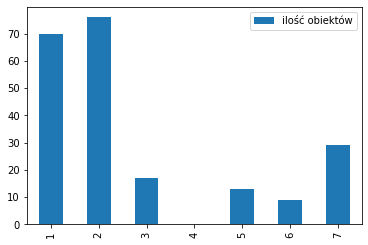

In [9]:
class_distr(glass_org)

Klasa 4 zostanie całkowicie pominięta w następujących rozważaniach i można ją traktować jako nieistniejącą. Z powodu braku jej próbek żaden obiekt nie będzie mógł zostać do niej przypisany.

Macierz korelacji Pearsona w celu ewentualnej eliminacji zbędnych atrybutów:

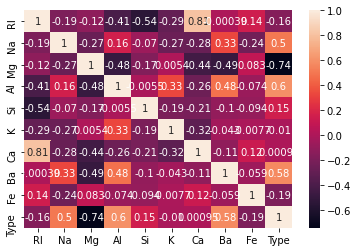

In [10]:
sns.heatmap(glass_org.corr(), annot = glass_org.corr())

Widać, że cecha Ca jest mocno skorelowana z cechą RI jednak nie wystarczająco, aby pominąć jedną z nich.

Macierz wykresów punktowych w celu lepszej wizualizacji zbioru:

In [ ]:
sns.pairplot(glass_org, kind="scatter", hue = "Type")

Widać, że cecha Ba może być dobrym wyznacznikiem przynależności obiektu do klasy 7. Wiele z histogramów przenika się w ogromnym stopniu.

Dane oryginalne podzielimy na część testową, której nie będziemy dalej ruszać, oraz na część treningową (uczącą), którą zoversamplujemy z użyciem SMOTE, aby wyrównać dystrybucję klas w celu lepszego trenowania:

In [20]:
def podziel(df, proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(
        df.iloc[:,0:-1], df.iloc[:,-1], test_size=proporcja)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

In [28]:
glass_org_dict = podziel(glass_org, 0.3)
sm = SMOTE()
X = glass_org_dict['opis_ucz']
y = glass_org_dict['dec_ucz']
X_res, y_res = sm.fit_resample(X, y)
glass_res = X_res
glass_res['Type'] = y_res

   ilość obiektów
1              59
2              59
3              59
4               0
5              59
6              59
7              59


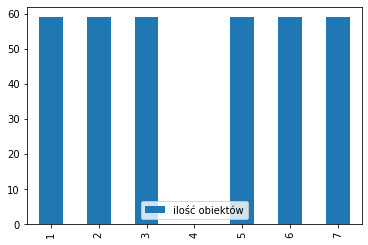

In [29]:
class_distr(glass_res)

Jak widać udało się wyrównać dystrubucje klas poza klasą, która od początku zawierała 0 obiektów. 

Weryfikacja z użyciem macierzy pomyłek:

In [30]:
def weryfikuj(model, proporcja):
    #pozwala sprawdzić z pomocą macierzy pomyłek jak działa dany model
    #zawsze operuje na oversamplowanych danych glass
    model.fit(glass_res.iloc[:,0:-1], glass_res.iloc[:,-1])
    
    wynik_ucz = model.predict(glass_res.iloc[:,0:-1])
    wynik_test = model.predict(glass_org_dict["opis_test"])
    
    print("Macierz pomyłek dla zbioru uczącego")
    print(pd.crosstab(glass_res.iloc[:,-1], wynik_ucz)) 
    wyn_test = model.score(glass_res.iloc[:,0:-1], glass_res.iloc[:,-1])
    print("Blad uczenia ", 1-wyn_test)
    
    print("\nMacierz pomyłek dla zbioru testowego")
    print(pd.crosstab(glass_org_dict["dec_test"], wynik_test)) 
    wyn_test = model.score(glass_org_dict["opis_test"], glass_org_dict["dec_test"])
    print("Blad testowania ", 1-wyn_test)

In [31]:
def wykres_bledu(max_k, proporcja):
    #tworzy wykres bledu dla algorytmu kNN by wybrać najlepsze k
    #testuje jak model klasyfikuje dane oryginalne czyli sprzed oversamplingu
    wyniki = []
    for i in range(1,max_k+1):
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(glass_res.iloc[:,0:-1], glass_res.iloc[:,-1])
        wyn_test = 1-model.score(glass_org_dict["opis_test"], glass_org_dict["dec_test"])
        wyniki.append(wyn_test)
    kwart = pd.DataFrame(wyniki, index=range(1,max_k+1))
    plt.figure(dpi=90)
    plt.plot(kwart,'bo-')
    plt.title('Wykres bledu')
    plt.xlabel('Liczba sasiadow')
    plt.ylabel('Prawdopodobienstwo bledu')

Szukanie najlepszego k dla algorytmu kNN. Jak widać poniżej najlepsze wyniki mamy dla k=1:

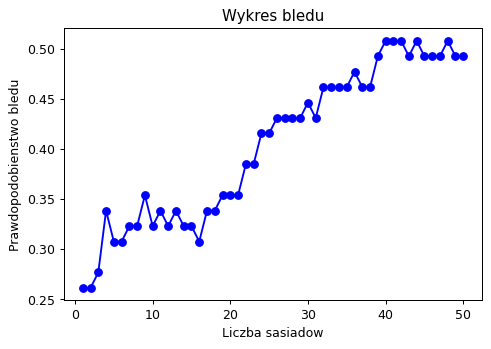

In [32]:
wykres_bledu(50, 0.3)

Zaskakująco dobre wyniki tak prostego algorytmu uczenia leniwego. Być może za bardzo dopasowany do zbioru uczącego. Akceptowalny błąd zbioru testowego. Warto zauważyć, że błąd uczenia jest bardzo niski (ryzyko przetrenowania):

In [38]:
model = KNeighborsClassifier(n_neighbors=1)
weryfikuj(model, 0.3)

Macierz pomyłek dla zbioru uczącego
col_0   1   2   3   5   6   7
Type                         
1      59   0   0   0   0   0
2       0  59   0   0   0   0
3       0   0  59   0   0   0
5       0   0   0  59   0   0
6       0   0   0   0  59   0
7       0   0   0   0   0  59
Blad uczenia  0.0

Macierz pomyłek dla zbioru testowego
col_0   1   2  3  5  6  7
Type                     
1      18   4  8  0  0  0
2       2  13  1  0  1  0
3       1   0  3  0  0  0
5       0   0  0  3  0  0
6       0   0  0  0  3  0
7       0   0  0  0  0  8
Blad testowania  0.2615384615384615


Już na pierwszy rzut oka widać, że ten algorytm nie będzie dla nas pomocny, gdyż ma bardzo kiepskie wyniki:

In [34]:
model = NearestCentroid()
weryfikuj(model, 0.3)

Macierz pomyłek dla zbioru uczącego
col_0   1  2   3   5   6   7
Type                        
1      29  7  23   0   0   0
2       4  9  39   7   0   0
3      15  4  40   0   0   0
5       0  2   4  51   0   2
6       0  7   0   4  48   0
7       0  3   2   2   0  52
Blad uczenia  0.3531073446327684

Macierz pomyłek dla zbioru testowego
col_0   1  2   3  5  6  7
Type                     
1      12  6  12  0  0  0
2       0  2  11  4  0  0
3       2  0   2  0  0  0
5       0  0   0  3  0  0
6       0  2   0  0  1  0
7       0  0   1  0  0  7
Blad testowania  0.5846153846153845


Również kiepskie wyniki bardzo podobne do tych w NearestCentroid:

In [35]:
model = GaussianNB()
weryfikuj(model, 0.3)

Macierz pomyłek dla zbioru uczącego
col_0   1   2   3   5   6   7
Type                         
1      20   2  36   0   1   0
2       6  10  38   2   3   0
3       2   0  56   0   1   0
5       0   5   0  51   0   3
6       0   0   0   0  59   0
7       1   1   0   4   0  53
Blad uczenia  0.2966101694915254

Macierz pomyłek dla zbioru testowego
col_0  1  2   3  5  6  7
Type                    
1      8  2  20  0  0  0
2      2  4   8  3  0  0
3      1  1   2  0  0  0
5      0  1   0  2  0  0
6      0  0   0  0  3  0
7      0  0   0  1  0  7
Blad testowania  0.6


Drzewo decyzyjne daje najlepsze wyniki (poza kNN=1) jednak wciąż są one o wiele gorsze niż kNN=1. Plusem tej metody jest nieprzetrenowanie modelu (większy błąd uczenia) co daje nadzieje na lepszą generalizację:

In [37]:
model = tree.DecisionTreeClassifier(max_depth=4)
weryfikuj(model, 0.3)

Macierz pomyłek dla zbioru uczącego
col_0   1   2   3   5   6   7
Type                         
1      38   1  20   0   0   0
2      12  43   4   0   0   0
3       0   0  59   0   0   0
5       0   0   0  59   0   0
6       0   0   0   0  59   0
7       1   1   0   0   1  56
Blad uczenia  0.11299435028248583

Macierz pomyłek dla zbioru testowego
col_0   1  2  3  5  6  7
Type                    
1      18  3  9  0  0  0
2       5  8  1  0  2  1
3       1  0  3  0  0  0
5       0  0  0  3  0  0
6       0  0  0  0  3  0
7       0  1  0  0  0  7
Blad testowania  0.3538461538461538


Stworzono model kNN=1 który daje dobre wyniki.